# Hotel Reservations

<img src="images/banner.png/" style="height:350px">

## Overview

The purpose of this project is to create a model to predict the number of hotel booking cancelations. This model will help hotel operations overbook hotel rooms in anticipation of cancelations, thus increasing profits of the hotel. I used the [Hotel Reservations Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset) to create this model. The final model is a Decision Tree Classifier evaluated with 85% accuracy, 86% precision, and an AUC of 0.8. The features with the greatest importance are lead time, reservations booked online, average price per room and the number of special requests. I recommend using the decision tree classifier to predict booking cancelations and overselling approximately 87% of those rooms to avoid losing money on cancelations. More work must be done to further fine tune the model.

## Business Understanding

With the ease of booking and canceling hotel reservations online, **hotel cancelations and no-shows have drastically increased**. This poses a significant problem for hotel revenue. Hotels are losing out on money when there are vacant rooms due to last minute cancelations. To combat this issue, I am going to create a model that can predict when a customer is going to cancel their reservation. This will allow the hotel to overbook an appropriate number of rooms so that they are not losing out on money due to vacant rooms while also not booking more rooms than there is space for in the hotel.

The stakeholders for this project are the hotel employees in charge of hotel bookings and operations, including the Reservations Manager, VP of Operations and, and VP of Revenue Management.

This business problem is important to the stakeholders because it is crucial to increase revenue coming from hotel room bookings. Additionally, they need to accurately manage vacancies for guests, which also impacts the price of the rooms.

In order to solve this business problem, I will investigate the following 3 questions:
1. Create a **model to predict** the number of hotel booking cancelations.
2. **Evaluate the model** to assess the efficacy in using it to predict cancelations.
3. Determine the **4 most important factors** that contribute to a cancelation.

## Data Understanding

The [Hotel Reservations Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset) extracted from Kaggle contains 36,275 entries of unique bookings ranging from 2017 to 2018. 

There are 19 columns, which are provided in the following data dictionary:

**Data Dictionary**

**Booking_ID**: unique identifier of each booking <br>
**no_of_adults**: Number of adults <br>
**no_of_children**: Number of Children <br>
**no_of_weekend_nights**: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel <br>
**no_of_week_nights**: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel <br>
**type_of_meal_plan**: Type of meal plan booked by the customer <br>
**required_car_parking_space**: Does the customer require a car parking space? (0 - No, 1- Yes)<br>
**room_type_reserved**: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels. <br>
**lead_time**: Number of days between the date of booking and the arrival date <br>
**arrival_year**: Year of arrival date <br>
**arrival_month**: Month of arrival date <br>
**arrival_date**: Date of the month <br>
**market_segment_type**: Market segment designation <br>
**repeated_guest**: Is the customer a repeated guest? (0 - No, 1- Yes) <br>
**no_of_previous_cancellations**: Number of previous bookings that were canceled by the customer prior to the current booking <br>
**no_of_previous_bookings_not_canceled**: Number of previous bookings not canceled by the customer prior to the current booking <br>
**avg_price_per_room**: Average price per day of the reservation; prices of the rooms are dynamic. (in euros) <br>
**no_of_special_requests**: Total number of special requests made by the customer (e.g. high floor, view from the room, etc) <br>
**booking_status**: Flag indicating if the booking was canceled or not <br>

The target variable will be `booking_status`.

First, I must import necessary libraries that I will use for the EDA and data preparation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree

%matplotlib inline

pd.options.mode.copy_on_write = True

# Suppress harmless warning for use_inf_as_na
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

Next I will load the dataset into the notebook.

In [2]:
data = pd.read_csv('data/hotel_reservations.csv')

## Data Preparation

To prepare the data for modeling, I will complete the following steps:
1. **Explore the data**: I will preview the first 5 rows of the data, investigate an overview of the data to view the data types, columns, and number of nulls. I want to remove any duplicate rows and determine which features are categorical and which are quantitative.
2. **Convert values to numeric**: To prepare data for machine learning, I want all values to be numeric. I convert string values from the target, `booking_status`, and from features `type_of_meal_plan`, `room_type_reserved`, and `market_segment_type` to numeric values.
3. **Train-test split**: I split the data using `train_test_split`before any other data transformation to prevent data leakage. I keep the default 0.25 test size and I shuffle the data.
4. **One Hot Encoder**: I use `OneHotEncoder` to create dummy variables for the categorial features. 
5. **Standard Scaler**: I use `StandardScaler` to standardize the quantitative features.

### Data Cleaning

In [3]:
# Preview the first 5 rows of the train data
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
# View the overall shape, dtypes and null counts for each column in train data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [5]:
# Check if there are any duplicates in the train data
data.duplicated(subset='Booking_ID').value_counts()

False    36275
Name: count, dtype: int64

There are no null values in the dataset. `repeated_guest` is of type integer but seems to be categorical, with 0 corresponsing to not a repeated guest and 1 corresponding to a repeated guest. 

In fact, our **categorical variables** are as follows: `type_of_meal_plan`, `required_car_parking_space`, `room_type_reserved`, `market_segment_type`, and `repeated_guest`. 

Our **quantitative variables** are `no_of_adults`, `no_of_children`, `no_of_weekend_nights`, `no_of_week_nights`, `lead_time`, `arrival_year`, `arrival_month`, `arrival_date`, `no_of_previous_cancellations`, `no_of_previous_bookings_not_canceled`, `avg_price_per_room`, and `no_of_special_requests`.

I will investigate the relationship between these features and the target, `booking_status`, to build a model that will predict whether a customer will cancel their reservation or not.

I am not using `Booking_ID` as a variable, as its purpose is just to confirm that each entry is a unique booking.

In [6]:
# Generate descriptive statistics of numerical variables in the data
data.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


I will convert the values in `booking_status` to 1 for 'Canceled' and 0 for 'Not_Canceled.'

In [7]:
# Convert values in the target column to 0's and 1's
data['booking_status'] = data['booking_status'].map({'Canceled': 1,
                                                       'Not_Canceled': 0})

# Confirm it has been done correctly
data['booking_status'].value_counts()

booking_status
0    24390
1    11885
Name: count, dtype: int64

I will now convert the rest of the variables with string variables to numerical variables. This will prepare my data for One Hot Encoding.

In [8]:
# Check how many value types are in each variable with string values
print(data['type_of_meal_plan'].value_counts())
print('\n')

print(data['room_type_reserved'].value_counts())
print('\n')

print(data['market_segment_type'].value_counts())

type_of_meal_plan
Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: count, dtype: int64


room_type_reserved
Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: count, dtype: int64


market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64


In [9]:
# Convert values in the type_of_meal_plan to numerical values
data['type_of_meal_plan'] = data['type_of_meal_plan'].map({'Not Selected': 0,
                                                             'Meal Plan 1': 1,
                                                             'Meal Plan 2': 2,
                                                             'Meal Plan 3': 3})

# Convert values in the room_type_reserved to numerical values
data['room_type_reserved'] = data['room_type_reserved'].map({'Room_Type 1': 1,
                                                             'Room_Type 2': 2,
                                                             'Room_Type 3': 3,
                                                             'Room_Type 4': 4,
                                                             'Room_Type 5': 5,
                                                             'Room_Type 6': 6,
                                                             'Room_Type 7': 7})


# Convert values in the market_segment_type to numerical values
data['market_segment_type'] = data['market_segment_type'].map({'Offline': 0,
                                                             'Online': 1,
                                                             'Corporate': 2,
                                                             'Complementary': 3,
                                                             'Aviation': 4})

### Data Transformation

Before transforming any data, I will use `train_test_split` to split my data into a train set and a test set. This is to prevent data leakage. When I test my model on the test set, I want it to mimic unknown data as best as possible. 

In [10]:
# Split dataset into features and target

X = data.drop(columns=['booking_status', 'Booking_ID'], axis = 1)
y = data['booking_status']

In [11]:
# Split the data into a train set and a test set using default values where 75% of the data is train and the remaining
# 25% is the test data
# Random state used for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=28)

Next, I will use `OneHotEncoder` on my categorical variables with no ordinal relationship

In [12]:
# Create dummy variables for categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Create dataframe with only the columns that require One Hot Encoding
categorical_train = X_train[['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 
                          'market_segment_type', 'repeated_guest']].copy()

categorical_test = X_test[['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 
                          'market_segment_type', 'repeated_guest']].copy()

# Fit the encoder on the training data and transform it
ohe.fit_transform(categorical_train)

# Transform the test data
ohe.transform(categorical_test)

# Create new dataframes with One Hot Encoded columns
categorical_train_ohe = pd.DataFrame(data=ohe.transform(categorical_train),
                                    columns=ohe.get_feature_names_out(),
                                    index=categorical_train.index)

categorical_test_ohe = pd.DataFrame(data=ohe.transform(categorical_test),
                                   columns=ohe.get_feature_names_out(),
                                   index=categorical_test.index)

Now, I will use `StandardScaler` to standardize the quantitative features.

In [13]:
# Initialize the scaler
scaler = StandardScaler()

# Create dataframe with only quantitative variables
quant_train = X_train[['arrival_year', 'arrival_month', 'arrival_date','no_of_adults', 'no_of_children', 
                   'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 
                   'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']].copy()

quant_test = X_test[['arrival_year', 'arrival_month', 'arrival_date','no_of_adults', 'no_of_children', 
                   'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 
                   'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']].copy()

# Fit and transform the train data
scaler.fit_transform(quant_train)

# Transform the test data
scaler.transform(quant_test)

# Create new dataframes with Scaler columns
quant_train_scaler = pd.DataFrame(data=scaler.transform(quant_train),
                                  columns=quant_train.columns,
                                  index=quant_train.index)

quant_test_scaler = pd.DataFrame(data=scaler.transform(quant_test),
                                  columns=quant_test.columns,
                                  index=quant_test.index)

In [14]:
# Append one hot encoded data back to dataframe
X_train_transformed = pd.concat([quant_train_scaler, categorical_train_ohe], axis=1)

X_test_transformed = pd.concat([quant_test_scaler, categorical_test_ohe], axis=1)

# Preview new dataframe
X_train_transformed.head()

,arrival_year,arrival_month,arrival_date,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,...,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,room_type_reserved_7,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_1
2947,0.46805,-0.136897,-0.642154,0.298216,2.20181,0.218603,-1.550369,-0.991105,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3033,0.46805,-1.758329,1.423318,-1.635357,-0.26098,1.363639,-0.847614,-0.979430,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30081,0.46805,0.835962,-1.101148,0.298216,4.66460,-0.926433,-0.847614,0.304761,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21861,0.46805,-1.434042,-1.330645,0.298216,-0.26098,1.363639,-0.144860,-0.664220,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11680,0.46805,0.835962,-0.986400,0.298216,-0.26098,-0.926433,-0.144860,-0.827662,-0.062816,-0.086268,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Modeling

### Baseline Understanding

The first model I create is a **logistic regression**. This is an appropriate baseline as logistic regressions are useful for **binary outcomes**. the binary outcome we are predicting in this case is whether a hotel booking will be canceled or not. 

Once the model is created, I examine the **p-values** of each of the features to determine **which features are statistically significant**. I will then use the statistically significant features for the future iterations of the model.

I **evaluate** this baseline model using the following metrics:
- **Accuracy**: This metric is used to measure the total number of predictions the model gets right, including both *true positives* and *true negatives*. This is a straight-forward metric that woudl be easy for stakeholders to understand.
- **Precision**: This metric is used to measure how precise the predictions are. In other words, *how many of the predicted positives are truly positive*? This is important in this model because if the model predicts that a reservation will be canceled, we want to ensure its precision before selling that room to another guest in the anticipation that the original reservation will be canceled. 
- **AUC**: This metric compares the false positive and true positive rates. We want this metric as close to 1.0 as possible, while 0.5 would be considered useless.
- **Confusion Matrix**: This visualizes the number of true positives, false positives, true negatives and false negatives. This visual is useful to show how many and what kind of errors the model is producing. In this instance, it is helpful to compare the number of false positives to the number of false negatves, as *we are looking to reduce the number of false positives*.

In [15]:
# Fit the logistic regression model using sklearn
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_transformed, y_train)

y_pred_train = logreg.predict(X_train_transformed)
y_pred_test = logreg.predict(X_test_transformed)

# Add a constant to the input features for the intercept
X_train_transformed = sm.add_constant(X_train_transformed)

# Get the coefficients and intercept from the fitted sklearn model
params = np.append(logreg.intercept_, logreg.coef_)

# Calculate the p-values using statsmodels
logit_model = sm.Logit(y_train, X_train_transformed)
result = logit_model.fit(disp=False)

# Print the summary to get the p-values
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27178
Method:                           MLE   Df Model:                           27
Date:                Thu, 25 Jul 2024   Pseudo R-squ.:                  0.3300
Time:                        21:35:53   Log-Likelihood:                -11492.
converged:                      False   LL-Null:                       -17153.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.0257      0.079    -25.741      0.000      -2.180      -1.871
arrival_year                             0.1654      

/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The above summary demonstrates that the following features are **not statistically significant** at an alpha value of 0.05: `arrival_date`, `no_of_previous_bookings_not_canceled`, `type_of_meal_plan_2`, `type_of_meal_plan_3`, `room_type_reserved_3`, `market_segment_type_3`. They can be removed for the next iteration of the model. 

Accuracy is :80.3977063882967

Precision is :73.38849592953423

AUC is :0.76

Confusion Matrix
----------------


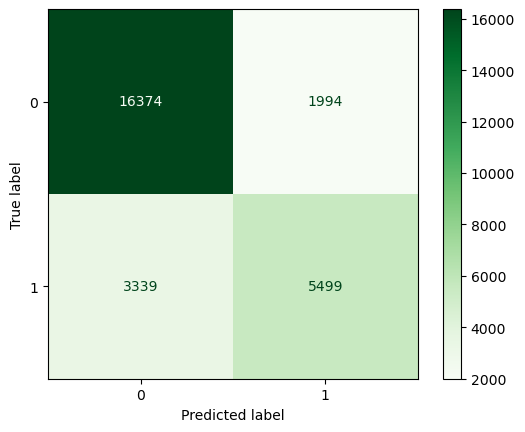

In [16]:
# Evaluation metrics for train set
# Calculate accuracy 
acc = accuracy_score(y_train,y_pred_train) * 100
print('Accuracy is :{0}'.format(acc))

# Calculate precision 
prec = precision_score(y_train,y_pred_train) * 100
print('\nPrecision is :{0}'.format(prec))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_train = confusion_matrix(y_train, y_pred_train)

cm_train_disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                      display_labels=logreg.classes_)
cm_train_disp.plot(cmap=plt.cm.Greens);

Accuracy is :80.41680449884221

Precision is :74.73725184896847

AUC is :0.76

Confusion Matrix
----------------


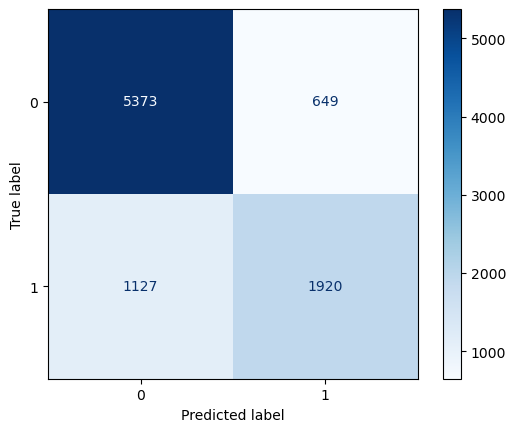

In [17]:
# Evaluation metrics for test set
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred_test) * 100
print('Accuracy is :{0}'.format(acc))

# Calculate precision 
prec = precision_score(y_test,y_pred_test) * 100
print('\nPrecision is :{0}'.format(prec))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_test = confusion_matrix(y_test, y_pred_test)

cm_test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=logreg.classes_)
cm_test_disp.plot(cmap=plt.cm.Blues);

The baseline model is performing slightly better on the test set than on the train set, but neither is performing particularly well. The test set demonstrates approximately **80% accuracy**, **75% precision** and an **AUC of 0.76**. These metrics does not give me confidence that we can accurately predict hotel booking cancelations. The model will need more tuning.

I will remove some features that are not helpful for the model. The features that are not statistically significant for this model include `arrival_date`, `no_of_previous_bookings_not_canceled`, `type_of_meal_plan_2`, `type_of_meal_plan_3`, `room_type_reserved_3`, and `market_segment_type_3`.

In [18]:
# Remove features that are not statistically significant with p-values above 0.05

X_train_transformed = X_train_transformed.drop(['const', 'arrival_date', 'no_of_previous_bookings_not_canceled', 'type_of_meal_plan_2', 
                                               'type_of_meal_plan_3', 'room_type_reserved_3', 'market_segment_type_3'], axis=1)

X_test_transformed = X_test_transformed.drop(['arrival_date', 'no_of_previous_bookings_not_canceled', 'type_of_meal_plan_2', 
                                               'type_of_meal_plan_3', 'room_type_reserved_3', 'market_segment_type_3'], axis=1)

### Modeling Iterations

I perform a series of **hyperparameter pruning and tuning** to produce the more efficient model to predict hotel booking cancelations. This model has 5 less features than the baseline model, as those that were not statistically significant were removed above. 

The first model iteration will be a **Decision Tree Classifier**. I will then tune the decision tree to make it more effective. 

Once the initial decision tree has been evaluated, I will then determine the ideal parameters for `max_depth` and `min_samples_split`. I investigate how `min_samples_leaf` and `max_features` effects the model, but ultimately determine that those are better left untouched for a better precision score.

In [19]:
# Instantiate classifier and fit it to the training data
classifier = DecisionTreeClassifier(criterion='entropy', random_state=28)

classifier.fit(X_train_transformed, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=28)

In [20]:
# Make predictions for train data
y_pred_train = classifier.predict(X_train_transformed)

# Make predictions for test data
y_pred_test = classifier.predict(X_test_transformed)

Below are the evaluation metrics for the train data and the test data. Unsurprisingly, the decision tree classifier overfit the data. When evaluating the model on the **train data** it produced **99% accuracy**, **99.5% precision**, and an **AUC of .99**.

When evaluating the model on the **test data** it produced **87% accuracy**, **81% precision**, and an **AUC of .85**. There are **565 false positives** and **601 false negatives**.

Accuracy is :99.33838123943248

Precision is :99.50823421774932

AUC is :0.99

Confusion Matrix
----------------


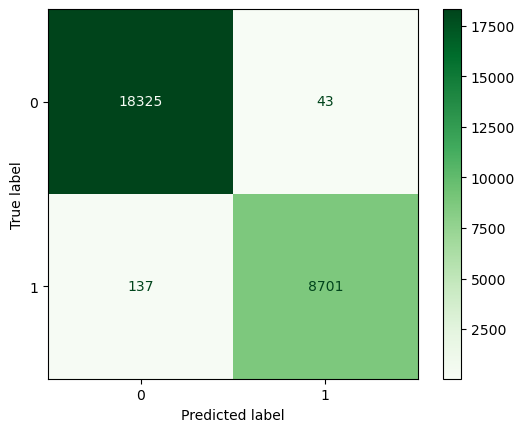

In [21]:
# Evaluate tree for train data

# Calculate accuracy 
acc = accuracy_score(y_train,y_pred_train) * 100
print('Accuracy is :{0}'.format(acc))

# Calculate precision 
prec = precision_score(y_train,y_pred_train) * 100
print('\nPrecision is :{0}'.format(prec))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_train = confusion_matrix(y_train, y_pred_train)

cm_train_disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                      display_labels=classifier.classes_)
cm_train_disp.plot(cmap=plt.cm.Greens);

Accuracy is :87.14301466534347

Precision is :81.23546994354035

AUC is :0.85

Confusion Matrix
----------------


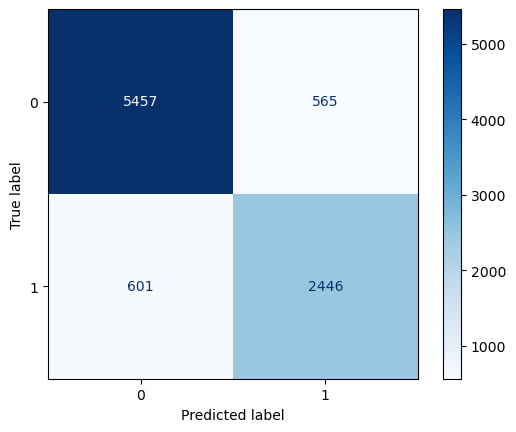

In [22]:
# Evaluate tree for test data

# Calculate accuracy 
acc = accuracy_score(y_test,y_pred_test) * 100
print('Accuracy is :{0}'.format(acc))

# Calculate precision 
prec = precision_score(y_test,y_pred_test) * 100
print('\nPrecision is :{0}'.format(prec))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_test = confusion_matrix(y_test, y_pred_test)

cm_test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=classifier.classes_)
cm_test_disp.plot(cmap=plt.cm.Blues);

I do want to create a model that will produce a much better precision score, however, because 81% is quite low given our goal. We want to determine how many rooms the hotel can oversell, given the prediction of cancelations. The hotel does not want to oversell rooms and end up without space for guests and having to cancel their reservations.

In this case, false negatives are better than false positive. A ***false positive* would be predicting that a hotel guest will cancel their reservation, but they end of keeping it**. A ***false negative* would be predicting that a hotel guest will keep their reservation but they end up canceling it**. We want to avoid false positives because that will lead to the hotel overselling too many rooms and not having enough rooms for the number of guests who kept their room reservations.

#### Hypertuning and Pruning

Below I will experiment with various parameters of the Decision Tree:
- **Maximum Depth**: I will reduce the depth of the tree to build a more generalized tree, since our initial tree overfit the train data. When plotting various values of maximum depths (`max_depth`), **7** appears to be optimal to increase precision and generally maintaining accuracy and AUC.
- **Minimum Samples Leaf With Split**: Setting a minimum number of samples required to split an internal node does not increase the efficacy of this model so I will leave this paramter out of the final model.
- **Minimum Leaf Sample Size**: Setting a minimum samples a leaf node should contain does not increase the efficacy of this model so I will leave this paramter out of the final model.
- **Maximum Features**: Restricting the number of features to consider when splitting a node does not increase the efficacy of this model so I will leave this parameter out of the final model.

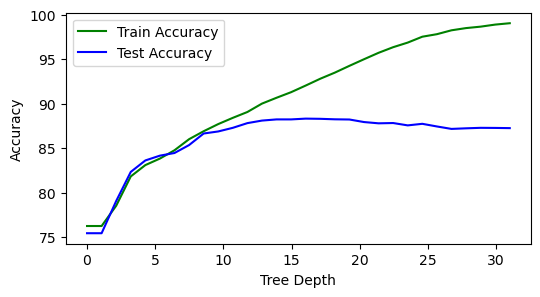

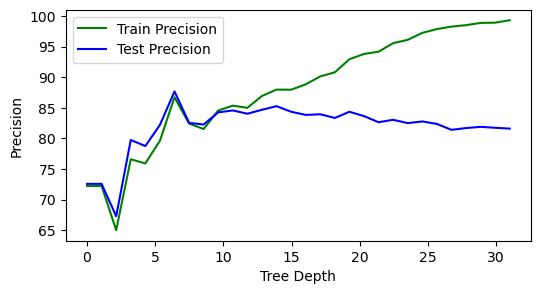

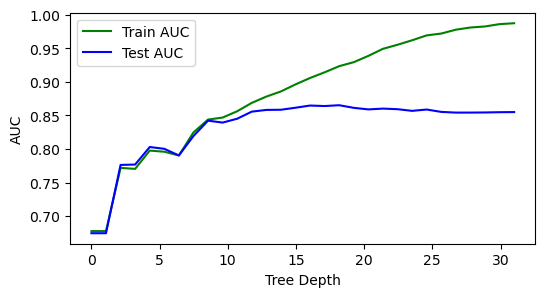

In [23]:
# Identify the optimal tree depth for the train data
acc_train = []
prec_train = []
aucs_train = []

for i in range(1, 31):
    classifier = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)


# Identify the optimal tree depth for the test data
acc = []
prec = []
aucs = []

for i in range(1, 31):
    classifier = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

# Plot accuracy for train and test data given various tree depths
plt.figure(figsize=(6,3))
plt.plot(np.linspace(0,31,30), acc_train, label='Train Accuracy', c='green')
plt.plot(np.linspace(0,31,30), acc, label='Test Accuracy', c='blue')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot precision for train and test data given various tree depths
plt.figure(figsize=(6,3))
plt.plot(np.linspace(0,31,30), prec_train, label='Train Precision', c='green')
plt.plot(np.linspace(0,31,30), prec, label='Test Precision', c='blue')
plt.xlabel('Tree Depth')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot AUC for train and test data given various tree depths
plt.figure(figsize=(6,3))
plt.plot(np.linspace(0,31,30), aucs_train, label='Train AUC', c='green')
plt.plot(np.linspace(0,31,30), aucs, label='Test AUC', c='blue')
plt.xlabel('Tree Depth')
plt.ylabel('AUC')
plt.legend()
plt.show()

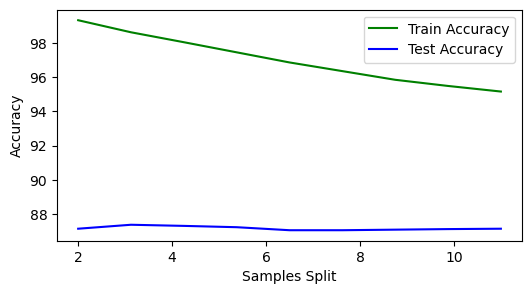

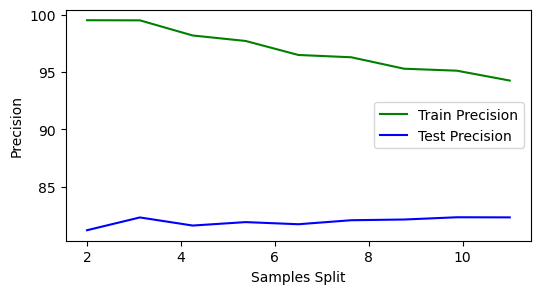

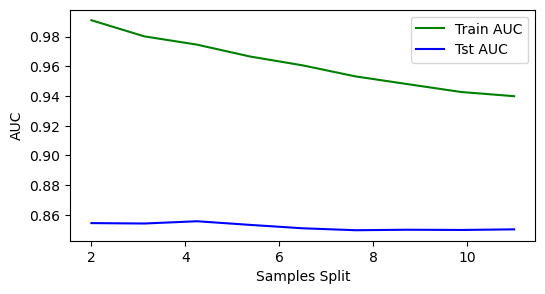

In [24]:
# Identify the optimal minimum samples split for the train data
acc_train = []
prec_train = []
aucs_train = []

for i in range(2, 11):
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)


# Identify the optimal minimum samples split for the test data
acc = []
prec = []
aucs = []

for i in range(2, 11):
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

# Plot accuracy for train and test data given various min samples split
plt.figure(figsize=(6,3))
plt.plot(np.linspace(2,11,9), acc_train, label='Train Accuracy', c='green')
plt.plot(np.linspace(2,11,9), acc, label='Test Accuracy', c='blue')
plt.xlabel('Samples Split')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot precision for train and test data given various min samples split
plt.figure(figsize=(6,3))
plt.plot(np.linspace(2,11,9), prec_train, label='Train Precision', c='green')
plt.plot(np.linspace(2,11,9), prec, label='Test Precision', c='blue')
plt.xlabel('Samples Split')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot AUC for train and test data given various min samples split
plt.figure(figsize=(6,3))
plt.plot(np.linspace(2,11,9), aucs_train, label='Train AUC', c='green')
plt.plot(np.linspace(2,11,9), aucs, label='Tst AUC', c='blue')
plt.xlabel('Samples Split')
plt.ylabel('AUC')
plt.legend()
plt.show()

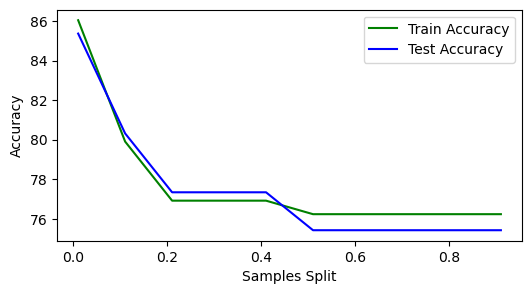

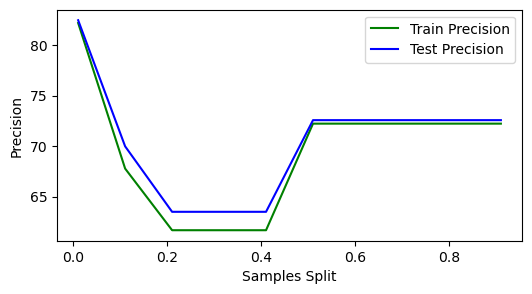

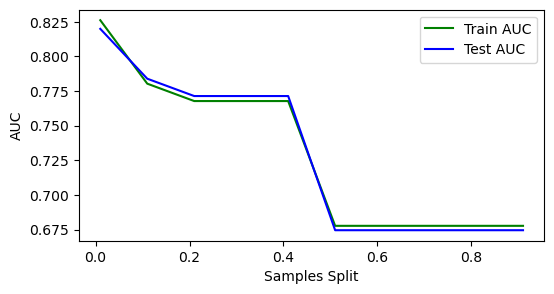

In [25]:
min_samples_splits = np.arange(0.01, 1.0, step=0.1)

# Identify the optimal minimum samples split for the train data
acc_train = []
prec_train = []
aucs_train = []

for min_samples_split in min_samples_splits:
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)


# Identify the optimal minimum samples split for the test data
acc = []
prec = []
aucs = []

for min_samples_split in min_samples_splits:
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

# Plot accuracy for train and test data given various min samples split
plt.figure(figsize=(6,3))
plt.plot(min_samples_splits, acc_train, label='Train Accuracy', c='green')
plt.plot(min_samples_splits, acc, label='Test Accuracy', c='blue')
plt.xlabel('Samples Split')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot precision for train and test data given various min samples split
plt.figure(figsize=(6,3))
plt.plot(min_samples_splits, prec_train, label='Train Precision', c='green')
plt.plot(min_samples_splits, prec, label='Test Precision', c='blue')
plt.xlabel('Samples Split')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot AUC for train and test data given various min samples split
plt.figure(figsize=(6,3))
plt.plot(min_samples_splits, aucs_train, label='Train AUC', c='green')
plt.plot(min_samples_splits, aucs, label='Test AUC', c='blue')
plt.xlabel('Samples Split')
plt.ylabel('AUC')
plt.legend()
plt.show()

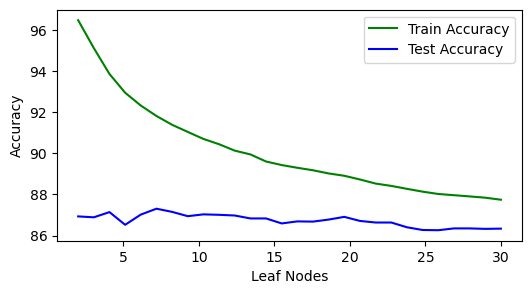

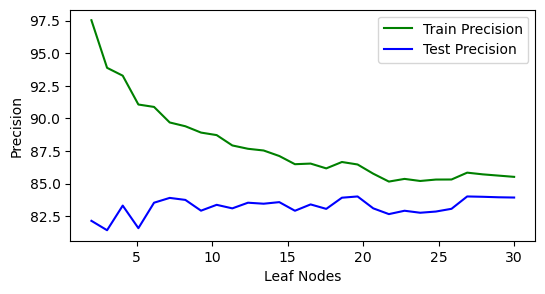

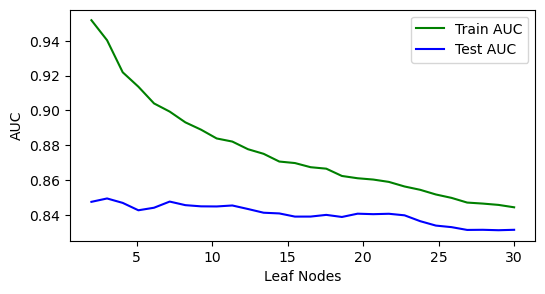

In [26]:
# Identify the optimal minimum samples leaf for the train data
acc_train = []
prec_train = []
aucs_train = []

for i in range(2, 30):
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)


# Identify the optimal minimum samples leaf for the test data
acc = []
prec = []
aucs = []

for i in range(2, 30):
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

# Plot accuracy for train and test data given various min samples leaf
plt.figure(figsize=(6,3))
plt.plot(np.linspace(2,30,28), acc_train, label='Train Accuracy', c='green')
plt.plot(np.linspace(2,30,28), acc, label='Test Accuracy', c='blue')
plt.xlabel('Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot precision for train and test data given various min samples leaf
plt.figure(figsize=(6,3))
plt.plot(np.linspace(2,30,28), prec_train, label='Train Precision', c='green')
plt.plot(np.linspace(2,30,28), prec, label='Test Precision', c='blue')
plt.xlabel('Leaf Nodes')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot AUC for train and test data given various min samples leaf
plt.figure(figsize=(6,3))
plt.plot(np.linspace(2,30,28), aucs_train, label='Train AUC', c='green')
plt.plot(np.linspace(2,30,28), aucs, label='Test AUC', c='blue')
plt.xlabel('Leaf Nodes')
plt.ylabel('AUC')
plt.legend()
plt.show()

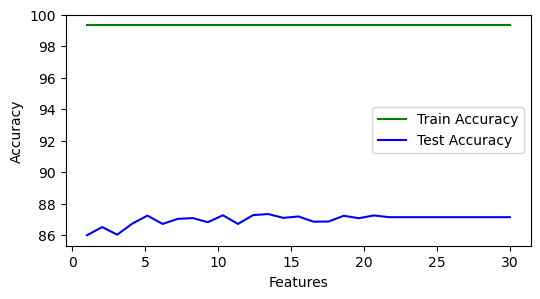

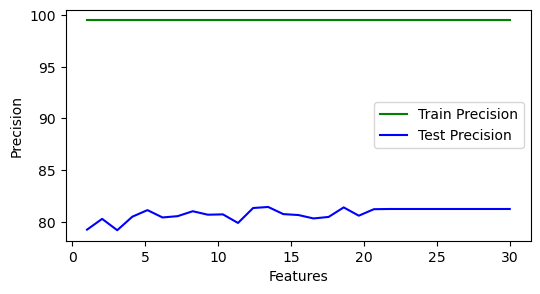

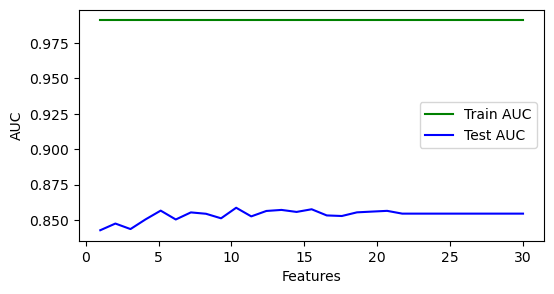

In [27]:
# Identify the optimal maximum features for the train data
acc_train = []
prec_train = []
aucs_train = []

for i in range(1, 30):
    classifier = DecisionTreeClassifier(criterion='entropy', max_features=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)


# Identify the optimal maximum features for the test data
acc = []
prec = []
aucs = []

for i in range(1, 30):
    classifier = DecisionTreeClassifier(criterion='entropy', max_features=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

# Plot accuracy for train and test data given various max features
plt.figure(figsize=(6,3))
plt.plot(np.linspace(1,30,29), acc_train, label='Train Accuracy', c='green')
plt.plot(np.linspace(1,30,29), acc, label='Test Accuracy', c='blue')
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot precision for train and test data given various max features
plt.figure(figsize=(6,3))
plt.plot(np.linspace(1,30,29), prec_train, label='Train Precision', c='green')
plt.plot(np.linspace(1,30,29), prec, label='Test Precision', c='blue')
plt.xlabel('Features')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot AUC for train and test data given various max features
plt.figure(figsize=(6,3))
plt.plot(np.linspace(1,30,29), aucs_train, label='Train AUC', c='green')
plt.plot(np.linspace(1,30,29), aucs, label='Test AUC', c='blue')
plt.xlabel('Features')
plt.ylabel('AUC')
plt.legend()
plt.show()

### Final Model

I use a **decision tree** as the final model. The `DecisionTreeClassifier` has the following parameter based on the previous investigation:
- `max_depth = 7`

I did not include `min_samples_split`, `min_samples_leaf` or `max_features`, as they just lowered the precision score for the model.

This model has the following evaluation metrics:
- **Accuracy**: ~85% (about 0.5% greater than the baseline model)
- **Precision**: ~86% (about 12% greater than the baseline model)
- **AUC**: 0.8 (0.04 greater than the baseline model)

There are 1066 false negatives and 315 false positives (both less than the baseline model).
- **False negatives**: Guest bookings that were predicted to keep their bookings but actually canceled them.
- **False positives**: Guest bookings that were predicted to cancel their bookings but actually kept them.

It is important in this business context to keep the false positive rate below the false negative rate. The hotel will be overselling rooms based on expected cancelations. It would be worse for the hotel to oversell too many rooms due to a false positive rate and have to cancel guests' reservations. The hotel can always book same day reservations if an anticipated reservation cancels that day.

Accuracy is :84.77230124600287

Precision is :86.28048780487805

AUC is :0.8

Confusion Matrix
----------------


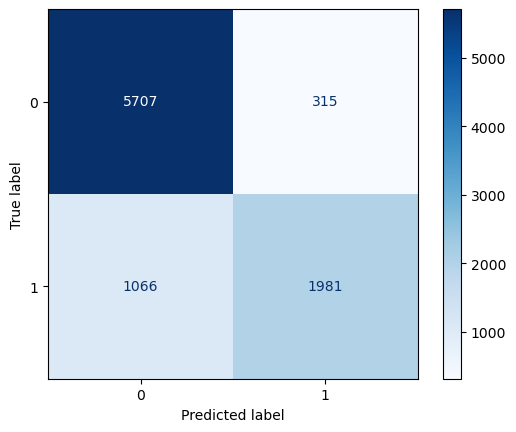

In [28]:
# Instantiate DecisionTreeClassifier 
classifier = DecisionTreeClassifier(max_depth=7, random_state=28)

# Fit the model to training data
classifier.fit(X_train_transformed, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test_transformed)

# Evaluate performance
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print('Accuracy is :{0}'.format(acc))

# Calculate precision 
prec = precision_score(y_test,y_pred) * 100
print('\nPrecision is :{0}'.format(prec))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm = confusion_matrix(y_test, y_pred)

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=classifier.classes_)
cm_disp.plot(cmap=plt.cm.Blues);

Below is a graph of the **features ranked in order of importance** for the decision tree classifier. The top 4 features are:
1. Lead Time
2. Reservation Booked Online (`market_segment_type_1`)
3. Average Price Per Room
4. Number of Special Requests

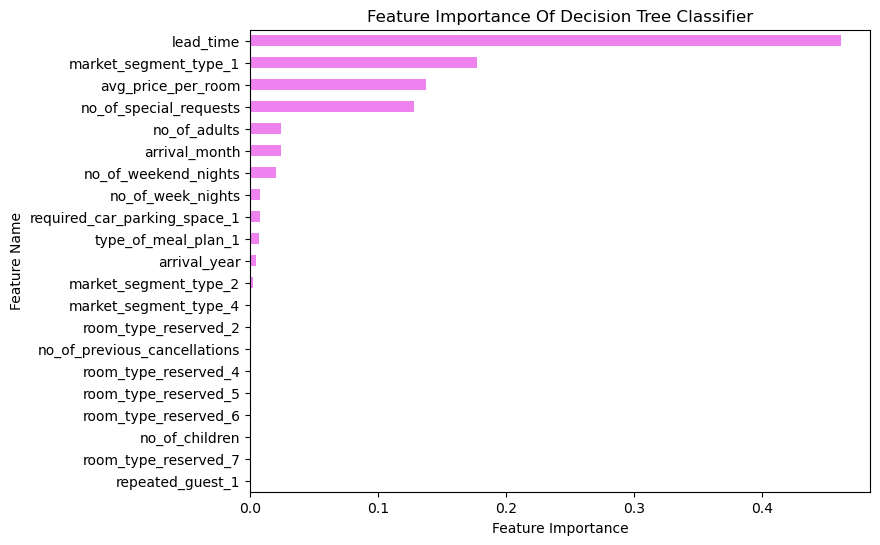

In [29]:
# Create bar chart with feature importance in descending order
feat_importances = pd.DataFrame(classifier.feature_importances_, index=X_train_transformed.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot(kind='barh', figsize=(8,6), color='Violet')
plt.title('Feature Importance Of Decision Tree Classifier')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.legend().remove();

## Conclusions

### Recommendations

1. I recommend **using a Decision Tree Classifier** with `max_depth=7`. This model can be used for predicting whether a customer will or will not cancel their hotel reservation. Once the number of expected cancelations is predicted, I would recommend **overselling approximately 87% of those rooms** to ensure the hotel does not lose money on the potential profits of those rooms.
2. The biggest factor of hotel booking cancelations is lead time - the number of days between the date of booking and the arrival date. That is followed by reservations booked online, average price per room and the number of special requests. I recommend further investigating **why and how these top 4 features effect booking cancelations**. 

### Limitations

- The Decision Tree Classifier produced a precision score of approximately 87%. This means that for all of the guest bookings that we predicted would cancel their reservations, approximately 13% would keep their reservations. I would like to see a **higher precision score**.
- The **dataset** is from 2017-2018, which is **outdated**. The data also is not from the current hotel company. These patterns may not accurately depict the behaviors of the stakeholders' clientele.

### Next Steps

Next steps would include :
1. Experiment with **different classifier models** to increase the precision score of the predictions. In other words, create a model with less false positives to more precisely predict the number of cancelations.
2. Gather recent data from the **current hotel company** to continue tuning and testing the model.
3. Further investigate the **top 4 factors** of hotel cancelations - lead time, online booking, average price per room and number of special requests. How can we use this knowledge to **retain guest reservations**?